In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import numpy as np
from scipy.stats import norm


from sklearn.preprocessing import MinMaxScaler
from torch import nn, optim
import torch

## Данные

In [2]:
values_dt = pd.read_csv('temp_ds/Power-Networks-LCL-June2015(withAcornGps)v2_2.csv', delimiter=',')
print(values_dt.keys())
#print(values['KWH/hh (per half hour) '])


values_dt = np.asarray(values_dt['KWH/hh (per half hour) '].dropna(how='any',axis=0))
values_dt[np.where(values_dt== 'Null')]=-1
values_dt = values_dt.astype(np.float32)
#print(values)

Index(['LCLid', 'stdorToU', 'DateTime', 'KWH/hh (per half hour) ', 'Acorn',
       'Acorn_grouped'],
      dtype='object')


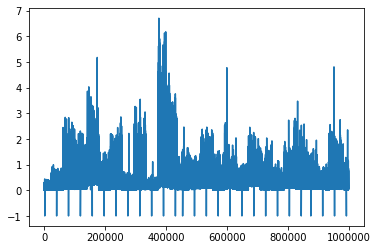

In [3]:
plt.plot(values_dt)

### Вспомогательные функции

In [4]:
def split_data(dt, splits_count = 20):
    all_arrays = []
    for i in range(0,len(dt)-len(dt)//splits_count,len(dt)//splits_count):
        newarr = dt[i:i + (len(dt)//splits_count)]
        all_arrays.append(newarr)
    return all_arrays
        
def moving_average(a, n=3) :
    ret = np.cumsum(a, dtype=float)
    ret[n:] = ret[n:] - ret[:-n]
    return ret[n - 1:] / n

def scaler(arr):
    scaler_orig = MinMaxScaler()
    scaler_orig = scaler_orig.fit(np.expand_dims(arr.ravel(), axis=1))
    data = scaler_orig.transform(np.expand_dims(arr, axis=1)) 
    return [scaler_orig, data]

def create_sequences(data, seq_length, t = 1):
    xs = []
    ys = []
    for i in range(len(data)-seq_length-t):
        x = data[i:(i+seq_length)]
        y = data[i+seq_length:i+seq_length+t]
        xs.append(x)
        ys.append(y)
    return np.array(xs), np.array(ys)

def train_test(values):
    
    test_data_size = int(len(values)*0.4)
    train_data = values[:-test_data_size]
    test_data = values[-test_data_size:]
    
    seq_length = 30
    X_train, y_train = create_sequences(train_data, seq_length, 1)
    indices = np.arange(len(X_train))
    np.random.shuffle(indices)
    X_train, y_train = X_train[indices], y_train[indices]

    X_test, y_test = create_sequences(test_data, seq_length, 1)
    X_train = torch.from_numpy(X_train).float()
    y_train = torch.from_numpy(y_train).float()

    X_test = torch.from_numpy(X_test).float()
    y_test = torch.from_numpy(y_test).float()
    
    return X_train, y_train, X_test, y_test

def generated(difference, predicted):
    mu, std = norm.fit(difference)
    s = abs(np.random.normal(mu+2.5, std**0.00001, len(predicted)))
    return predicted * s 

In [38]:
class TempNN(nn.Module):
    def __init__(self, n_features, n_hidden, seq_len, n_layers=2):
        super(TempNN, self).__init__()
        self.n_hidden = n_hidden
        self.seq_len = seq_len
        self.n_layers = n_layers
        self.norm = nn.LayerNorm(self.seq_len)
        self.lstm = nn.LSTM(
          input_size=n_features,
          hidden_size=n_hidden,
        )
        self.linear = nn.Linear(in_features=n_hidden, out_features=1)
        self.activate = nn.Tanh()
    def reset_hidden_state(self):
        self.hidden = (
            torch.zeros(self.n_layers, self.seq_len, self.n_hidden),
            torch.zeros(self.n_layers, self.seq_len, self.n_hidden)
        )
    def forward(self, sequences):
       # sequences = self.norm
        lstm_out, self.hidden = self.lstm(
          sequences.view(len(sequences), self.seq_len, -1),
          self.hidden
        )
        last_time_step = lstm_out.view(self.seq_len, len(sequences), self.n_hidden)[-1]
      #  y_pred = self.activate(last_time_step)
        y_pred = self.linear(last_time_step)
        
        #y_pred = self.activate(last_time_step)
        
        return y_pred

def train_model( model, train_data, train_labels,test_data=None, test_labels=None ):
    loss_fn = torch.nn.MSELoss()
    optimiser = torch.optim.Adam(model.parameters(), lr=0.001)
    num_epochs = 100
    train_hist = np.zeros(num_epochs)
    test_hist = np.zeros(num_epochs)
    model.reset_hidden_state()
 
    for t in range(num_epochs):
        
        print(t)
        y_pred = model(X_train)
        #print("ueueu")
        loss = loss_fn(y_pred.float(), y_train)
        
        if test_data is not None:
            with torch.no_grad():
                y_test_pred = model(X_test)
                test_loss = loss_fn(y_test_pred.float(), y_test)
            test_hist[t] = test_loss.item()
        if t % 2 == 0:
            print(f'Epoch {t} train loss: {loss.item()} test loss: {test_loss.item()}')
        elif t % 2 == 0:
            print(f'Epoch {t} train loss: {loss.item()}')
        train_hist[t] = loss.item()
        if t!= 0 and train_hist[t-1]<train_hist[t]:
            break
        optimiser.zero_grad()
        loss.backward()
        optimiser.step()
        
    return model.eval(), train_hist, test_hist

### Нарезка данных на батчи

In [93]:
splited = split_data(values_dt, 100) #Нарезаем на 100 батчей
avg_splited = [moving_average(splited[i],100) for i in range(len(splited))] #Усредняем
scalers_data = np.asarray([scaler(avg_splited[i]) for i in range(len(avg_splited))]) #Нормализуем
datas = scalers_data[:,1] # Данные (батчи)
scalers = scalers_data[:,0] # Скейлеры

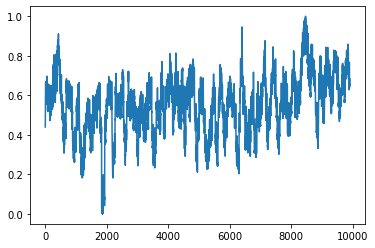

In [94]:
plt.plot(datas[0])

### Обучение и тестирование

In [95]:
model = TempNN( n_features=1, n_hidden= 64, seq_len=30, n_layers=1)

In [96]:
for i,data in enumerate(datas):
    print("Batch №%d"%i)
    X_train, y_train, X_test, y_test = train_test(data)
    y_train = torch.reshape(y_train,(-1, 1))
    y_test = torch.reshape(y_test,(-1, 1)) 
    model, train_hist, test_hist = train_model( model, X_train, y_train, X_test, y_test)

Batch №0
0
Epoch 0 train loss: 0.36947184801101685 test loss: 0.48167574405670166
1
2
Epoch 2 train loss: 0.33375945687294006 test loss: 0.43698373436927795
3
4
Epoch 4 train loss: 0.3000851273536682 test loss: 0.3946841061115265
5
6
Epoch 6 train loss: 0.26752588152885437 test loss: 0.35353368520736694
7
8
Epoch 8 train loss: 0.23515167832374573 test loss: 0.31236159801483154
9
10
Epoch 10 train loss: 0.20212513208389282 test loss: 0.2700810730457306
11
12
Epoch 12 train loss: 0.16778822243213654 test loss: 0.2257426381111145
13
14
Epoch 14 train loss: 0.13161693513393402 test loss: 0.1784592717885971
15
16
Epoch 16 train loss: 0.09341098368167877 test loss: 0.1275925487279892
17
18
Epoch 18 train loss: 0.05441075563430786 test loss: 0.07411383092403412
19
20
Epoch 20 train loss: 0.02273828350007534 test loss: 0.027734465897083282
21
22
Epoch 22 train loss: 0.03605180233716965 test loss: 0.03755015507340431
Batch №1
0
Epoch 0 train loss: 0.05075547844171524 test loss: 0.08389604091644

KeyboardInterrupt: 

In [10]:
torch.save(model.state_dict(), "models/energy_model.pth")

In [97]:
j = 23
X_train, y_train, X_test, y_test = train_test(scalers[j].inverse_transform(datas[j]))
# y_train = torch.reshape(y_train,(-1, 1))



In [98]:
i = 1
seq_length = 30
test_seq = X_test[i-1:i]
preds = []
seqs = []
for _ in range(len(X_test)):
    sc, dt = scaler(X_test[i-1:i].numpy().ravel())
    dt = torch.from_numpy(dt.reshape(1,-1))
    y_test_pred = model(dt)
    
    y_test_pred = sc.inverse_transform(y_test_pred.detach().numpy())
   # print(y_test_pred)
    i+=1
    pred = y_test_pred[0,0]
    preds.append(pred)
    new_seq = test_seq.numpy().flatten()
    new_seq = np.append(new_seq, [pred])
    new_seq = new_seq[1:]


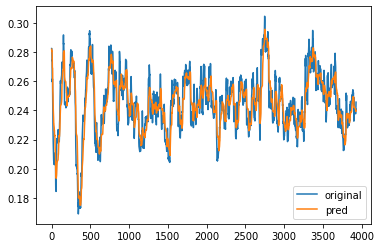

In [99]:

plt.plot((np.asarray(y_test).reshape(1,-1)).ravel(), label = "original")
plt.plot(preds, label = "pred")
plt.legend()

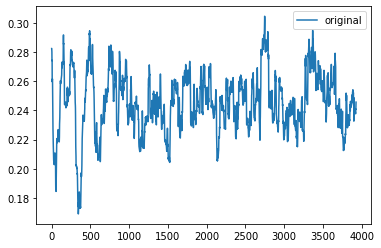

In [100]:

plt.plot((np.asarray(y_test).reshape(1,-1)).ravel(), label = "original")
plt.legend()

### Смотрим модель на разных отрезков данных

In [103]:
def predict_batch(data, lstm, slice_size = 30):    
    """
    data - time series for forecasting.
    lstm - model for predicting trend.
    sclice_size - count of data to prediction
    """
    series_lstm1 =[]
    differs = []
    
    series_lstm2 = []
    for i in range(slice_size, len(data)):
        numval = np.asarray(data[i-slice_size:i]).reshape(1,slice_size)
        sc, numval = scaler(numval.ravel())
        
     #   numval = numval.ravel()
        val = torch.from_numpy(numval[:].reshape(1,-1)).float()
       # print(val)
        predict_1 = lstm(val) 
        predict_1 = sc.inverse_transform(predict_1.detach().numpy())
       # print(predict_1)
        series_lstm1.append(predict_1)
    return series_lstm1

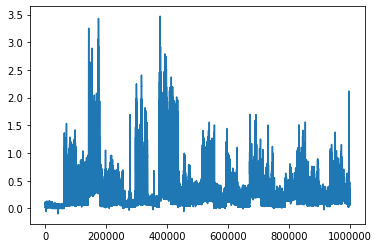

In [104]:
values_rm = moving_average(values_dt,10)
plt.plot(values_rm)

In [124]:
batch = values_rm[70000:85000]
batch_orig = values_dt[70000:85000]

predicted = predict_batch(batch, model, slice_size = 30)

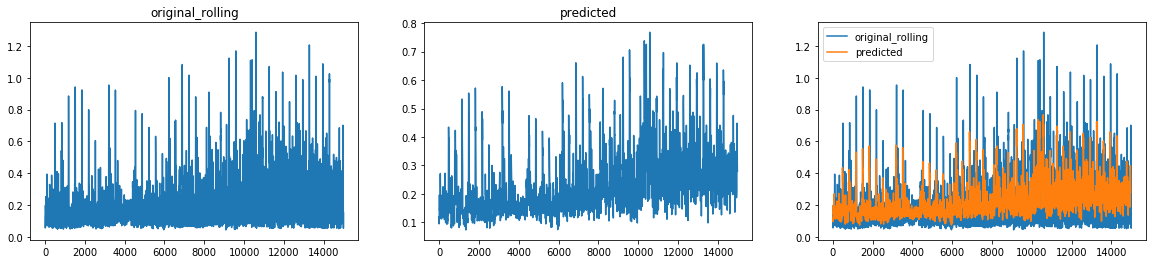

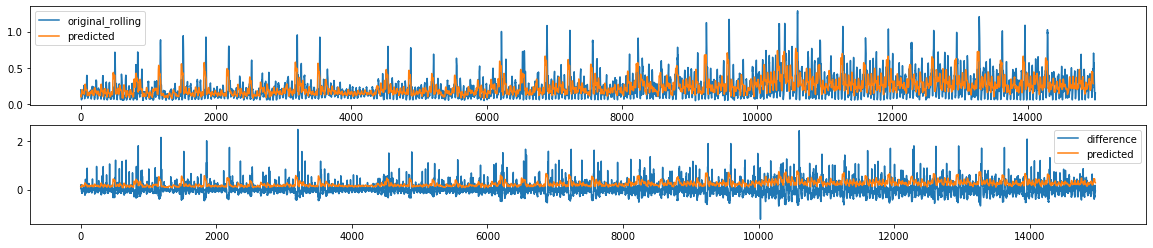

In [125]:
plt.figure(figsize = (20,4))
plt.subplot(1,3,1)
plt.plot(batch)
plt.title ("original_rolling")
plt.subplot(1,3,2)
plt.plot(np.asarray(predicted).ravel())
plt.title ("predicted")
plt.subplot(1,3,3)
plt.plot(batch, label = "original_rolling")
plt.plot(np.asarray(predicted).ravel(), label = "predicted")
plt.legend()
plt.show()

plt.figure(figsize = (20,4)) 

plt.subplot(2,1,1)
plt.plot(batch, label = "original_rolling")
plt.plot(np.asarray(predicted).ravel(), label = "predicted")
plt.legend()
plt.subplot(2,1,2)
plt.plot(np.asarray(batch_orig)[:len(batch)-30] - np.asarray(predicted).ravel(), label = "difference")
plt.plot(np.asarray(predicted).ravel(), label = "predicted")
plt.legend()
plt.show()

### Добавляем шум

In [108]:
difference = np.asarray(batch_orig)[:len(batch)-30] - np.asarray(predicted).ravel()
with_noise = generated(difference, np.asarray(predicted).ravel())

Text(0.5, 1.0, 'Generated data')

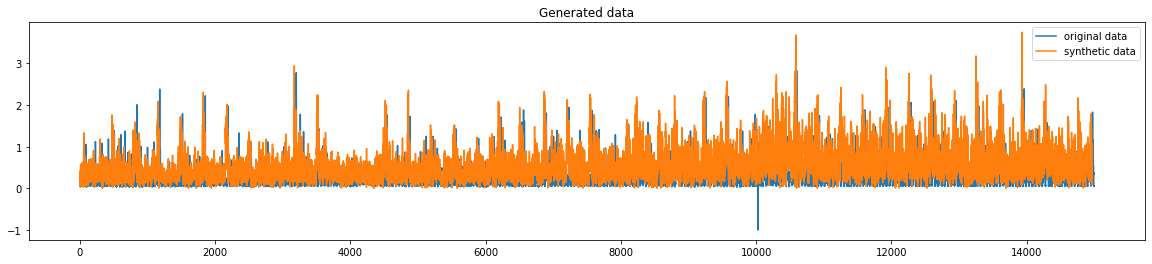

In [109]:
plt.figure(figsize = (20,4)) 
plt.plot(np.asarray(batch_orig)[:24970], label = "original data")
plt.plot(with_noise, label = "synthetic data")
plt.legend()
plt.title("Generated data")

### Две LSTM

In [114]:
def predict_summation_batch(data, lstm, slice_size = 30):    
    """
    data - time series for forecasting.
    lstm - model for predicting trend.
    lstm2 - model for predictin diff.
    sclice_size - count of data to prediction
    """
    series_lstm1 =[]
    differs = []
    series_lstm2 = []
    for i in range(slice_size, len(data)):
        numval = np.asarray(data[i-slice_size:i]).reshape(1,slice_size)
        sc, numval = scaler(numval.ravel())
        val = torch.from_numpy(numval[:].reshape(1,-1)).float()
        predict_1 = lstm(val) 
        predict_1 = sc.inverse_transform(predict_1.detach().numpy())
       # print(predict_1)
        series_lstm1.append(predict_1)
        differs.append(data[i] - predict_1) 
        if len(series_lstm1) >= slice_size:
            lenght = len(series_lstm1)
            value = np.asarray(differs[lenght-slice_size:lenght])
            sc, numval = scaler(value.ravel())
            numval = sc.transform(np.asarray(numval[:].reshape(1,slice_size)))
            val = torch.from_numpy(numval).float()
            predict_2 = lstm(val[:1]) 
            predict_2 = sc.inverse_transform(predict_2.detach().numpy())
            series_lstm2.append(predict_2)
    series_lstm2 = np.asarray(series_lstm2)
    series_lstm1 = np.asarray(series_lstm1)
    differs = np.asarray(differs)
  #  series_lstm1 = scaler.inverse_transform(np.asarray(series_lstm1).reshape(-1,1))
    return series_lstm1[:len(series_lstm2)].ravel(), series_lstm2.ravel(), differs.ravel()

In [115]:
batch = values_rm[80000:95000]
batch_orig = values_dt[80000:95000]

In [116]:
predicted = predict_summation_batch(batch_orig, model, slice_size = 30)

In [117]:
summation = np.asarray(predicted[0]).ravel() + np.asarray(predicted[1]).ravel()

In [118]:
from sklearn.metrics import mean_squared_error

Text(0.5, 1.0, 'Two lstm prediction')

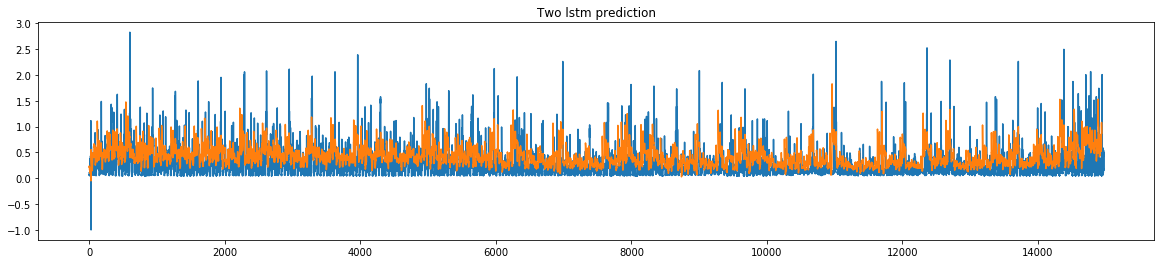

In [119]:
%matplotlib inline
plt.figure(figsize = (20,4)) 
plt.plot(np.asarray(batch_orig)[:len(batch_orig) - 30], label = "original")
plt.plot(summation, label = "prediction")
plt.title("Two lstm prediction")

#plt.plot(predicted[1])

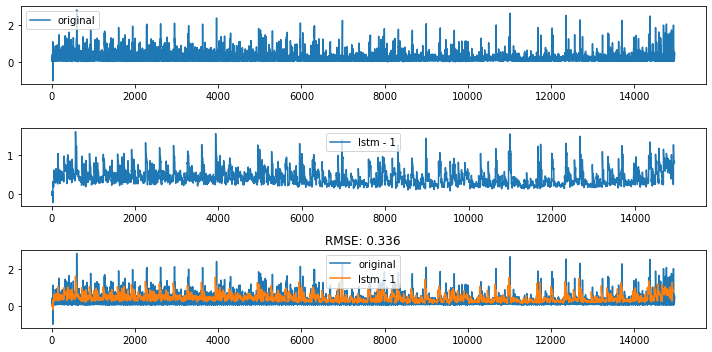

In [120]:
plt.figure( figsize = (10,5))
plt.subplot(3,1,1)
plt.plot(np.asarray(batch_orig)[:len(batch_orig) - 30], label = "original")
plt.legend()
plt.subplot(3,1,2)
plt.plot(predicted[0].ravel(), label = "lstm - 1")
plt.legend()
plt.subplot(3,1,3)
plt.plot(np.asarray(batch_orig)[:len(batch_orig) - 30], label = "original")
plt.plot(predicted[0].ravel(), label = "lstm - 1")
plt.legend()
mse = mean_squared_error(predicted[0], np.asarray(batch_orig)[:len(batch_orig) - 59])
plt.title("RMSE: %.3f"% mse**0.5)
plt.tight_layout()

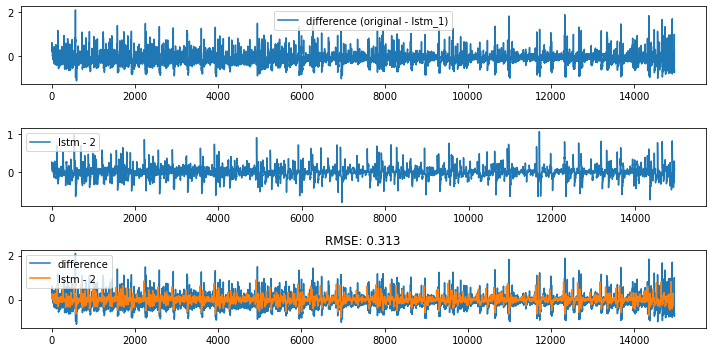

In [121]:
plt.figure( figsize = (10,5))
plt.subplot(3,1,1)
plt.plot(predicted[2].ravel(), label = "difference (original - lstm_1)")
plt.legend()
plt.subplot(3,1,2)
plt.plot(predicted[1].ravel(), label = "lstm - 2")
plt.legend()
plt.subplot(3,1,3)

mse = mean_squared_error(predicted[2].ravel()[:len(predicted[1])], predicted[1].ravel())
plt.title("RMSE: %.3f"% mse**0.5)
plt.plot(predicted[2].ravel(), label = "difference")
plt.plot(predicted[1].ravel(), label = "lstm - 2")
plt.legend()
plt.tight_layout()

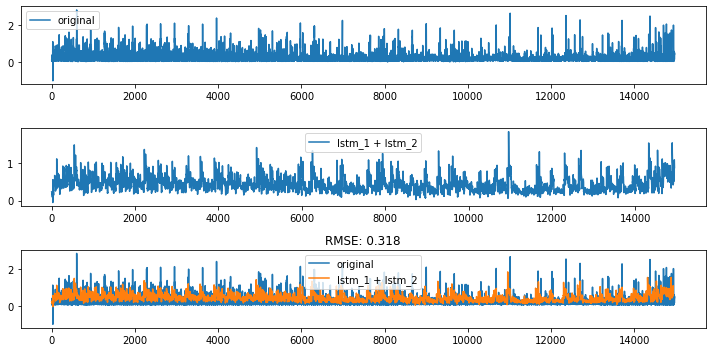

In [122]:
plt.figure( figsize = (10,5))
plt.subplot(3,1,1)
plt.plot(np.asarray(batch_orig)[:len(batch_orig) - 30], label = "original")
plt.legend()
plt.subplot(3,1,2)
plt.plot(summation.ravel(), label = "lstm_1 + lstm_2")
plt.legend()
plt.subplot(3,1,3)
mse = mean_squared_error(np.asarray(batch_orig)[:len(summation)], summation.ravel())
plt.title("RMSE: %.3f"% mse**0.5)
plt.plot(np.asarray(batch_orig)[:len(batch_orig) - 30], label = "original")
plt.plot(summation.ravel(), label = "lstm_1 + lstm_2")
plt.legend()
plt.tight_layout()